In [1]:
from PIL import Image # Reading and manipulating images
import numpy as np # Math stuff
import matplotlib.pyplot as plt # Plot stuff
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans

## Reading the image

We are going to digitize Figure 4 from di Luzio, Guerrera, Ponce and Rigolin, [arXiv:2402.12454](https://arXiv.org/abs/2402.12454)

Text(0, 0.5, 'y')

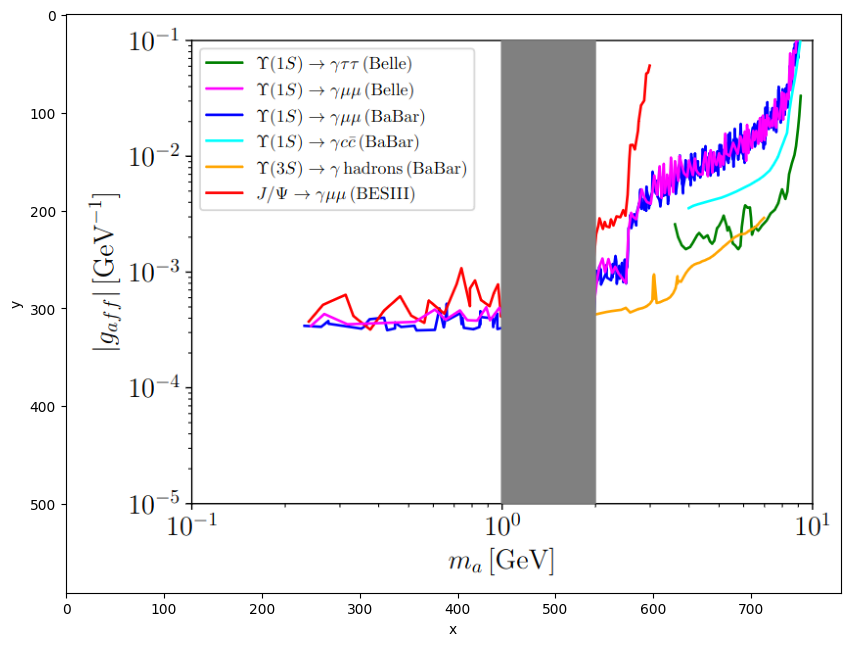

In [2]:
img = Image.open('plot.png')

plt.figure(figsize=(10,10))
plt.imshow(np.asarray(img))
plt.xlabel('x')
plt.ylabel('y')

This is our plot-in-a-plot. Notice that the origin of coordinates for the image is located at the top left, and positive $y$ increases downwards.

## Defining the box

Now we define the box where we are going to look for the points of interest:

In [3]:
min_x = 200
max_x = 650
min_y = 40
max_y = 400

Text(0, 0.5, 'y')

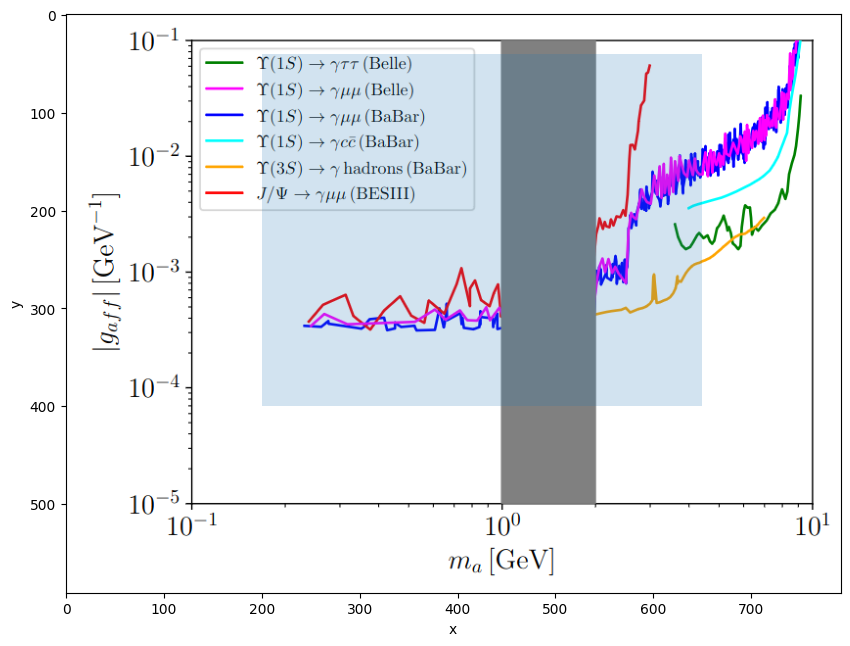

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.asarray(img))
ax = plt.gca()
ax.add_patch(Rectangle((min_x, min_y), max_x-min_x, max_y-min_y, alpha=0.2))
plt.xlabel('x')
plt.ylabel('y')

Only the points in the blue box will be digitized. This is useful, for example, to avoid the color parts of the legend.

## Extracting the data points

First, let us see what are the colors used in the plot. In order to avoid similar colors (e.g. due to aliasing), we cluster the colors using the $k$-means algorithm

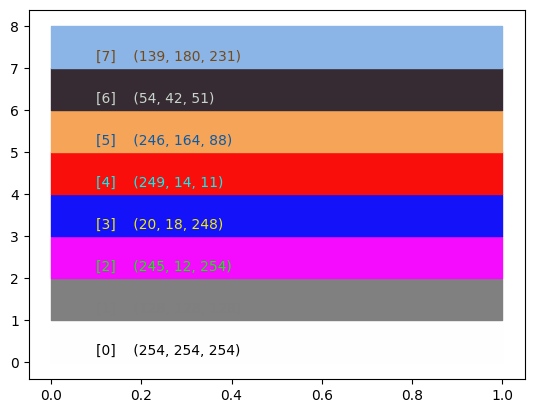

In [11]:
points = []
for x in range(min_x, max_x):
    for y in range(min_y, max_y):
        points.append(img.getpixel((x, y))[:3])

km = KMeans(8).fit(points)
colors = km.cluster_centers_

for i, center in enumerate(colors):
    plt.fill_between([0,1], [i,i], [i+1, i+1], color=np.array(center)/255)
    plt.annotate(f'[{i}]    ({round(center[0])}, {round(center[1])}, {round(center[2])})', (0.1, i+0.2), color=np.array([1,1,1])-np.array(center)/255)

We are going to extract the data points corresponding to $J/\psi\to\gamma\mu\mu$ measured by BESIII. In order to do that, we select the points in red, corresponding to `colors[4]`. We will consider candidate points whose color distance is less than 50, and for each $x$ we extract the $y$-coordinate of the candidate point that minimizes the color distance.

In [12]:
color = colors[4]
col_tol = 50

In [13]:
xpos = []
ypos = []
for x in range(min_x, max_x):
    y_0 = 0
    d_0 = 5000
    for y in range(min_y, max_y):
        pixel = img.getpixel((x, y))
        col_dist = ((pixel[0]-color[0])**2+(pixel[1]-color[1])**2+(pixel[2]-color[2])**2)**0.5
        if col_dist < col_tol and col_dist < d_0:
                d_0 = col_dist
                y_0 = y
    if d_0 < 5000:
        ypos.append(y_0)
        xpos.append(x)

The points will appear in the opposite color (in this case, cyan).

Text(0, 0.5, 'y')

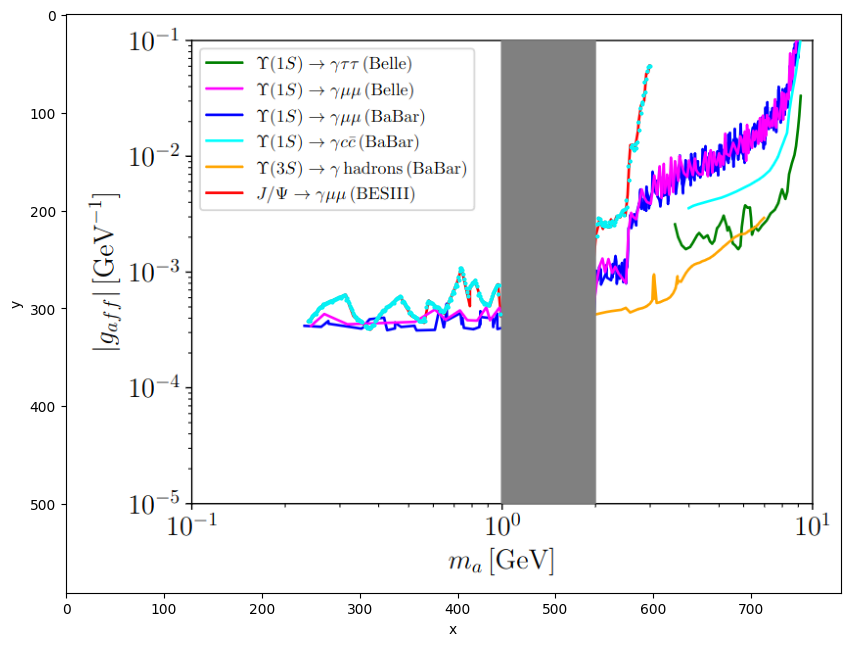

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(np.asarray(img))
ax = plt.gca()
plt.scatter(xpos, ypos, s=4, color=((255-color[0])/255, (255-color[1])/255, (255-color[2])/255))
plt.xlabel('x')
plt.ylabel('y')

## Scaling and transforming the data

Image coordinates are not very useful, so we will have to translate them. First we define the image-coords of two reference $x$ points and two reference $y$ values to calibrate.

In [15]:
xref1 = 128
xref2 = 761

yref1 = 27
yref2 = 500

The coords of `xref1` and `yref1` are marked in red, and `xref2` and `yref2` in blue.

Text(0, 0.5, 'y')

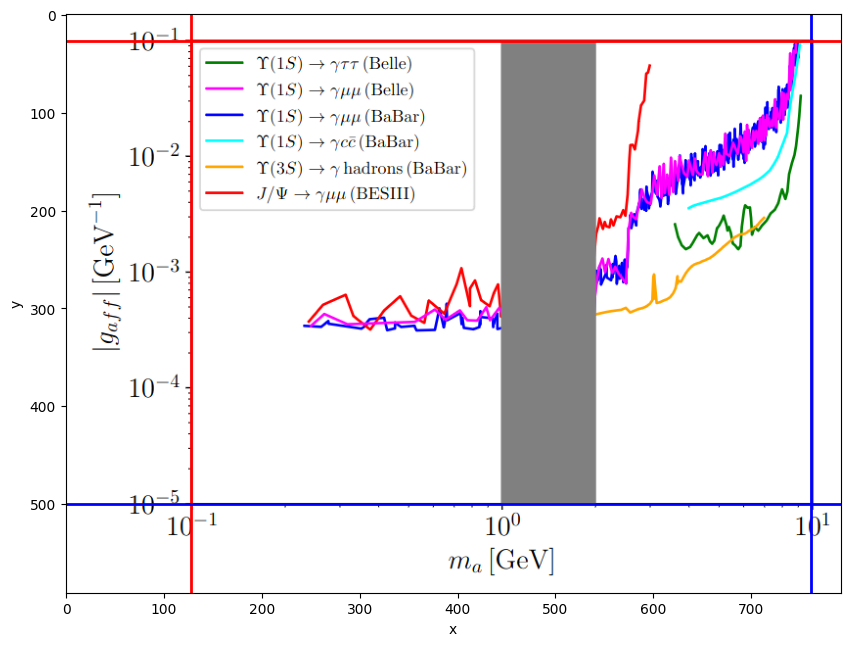

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(np.asarray(img))
ax = plt.gca()
plt.axvline(xref1, c='r', lw=2)
plt.axvline(xref2, c='b', lw=2)
plt.axhline(yref1, c='r', lw=2)
plt.axhline(yref2, c='b', lw=2)
plt.xlabel('x')
plt.ylabel('y')

Now we enter the corresponding values for the reference points. We also decide if the scale is linear or logarithmic.

In [17]:
xval1 = 1e-1
xval2 = 10

yval1 = 1e-1
yval2 = 1e-5

logx = True
logy = True

If your scale needs a transformation that is not linear or logarithmic, you can define your custom direct and inverse transformations.

In [18]:
if logx:
    transf_x = np.log10
    transfinv_x = lambda x: 10**x
else:
    transf_x = lambda x: x
    transfinv_x = lambda x: x

if logy:
    transf_y = np.log10
    transfinv_y = lambda x: 10**x
else:
    transf_y = lambda x: x
    transfinv_y = lambda x: x
    
slope_x = (transf_x(xval1)-transf_x(xval2))/(xref1-xref2)
b_x = transf_x(xval1)-slope_x*xref1
data_x = transfinv_x(np.array(xpos)*slope_x+b_x)

slope_y = (transf_y(yval1)-transf_y(yval2))/(yref1-yref2)
b_y = transf_y(yval1)-slope_y*yref1
data_y = transfinv_y(np.array(ypos)*slope_y+b_y)

Now the data is transformed, so we can plot it:

In [19]:
xname = "ma_GeV"
yname = "gaff_GeV-1"

Text(0, 0.5, 'gaff_GeV-1')

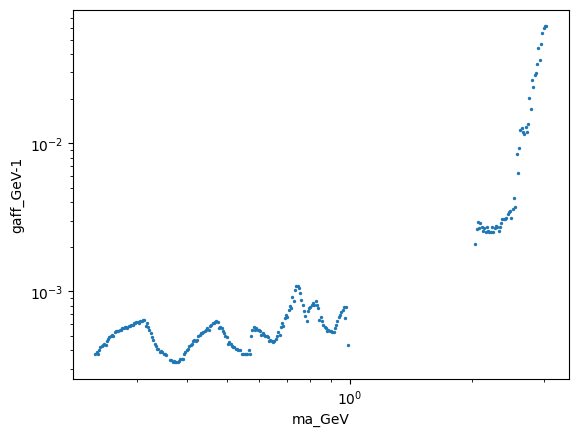

In [20]:
plt.scatter(data_x, data_y, s=2)
ax = plt.gca()
if logx:
    ax.set_xscale('log')
if logy:
    ax.set_yscale('log')
plt.xlabel(xname)
plt.ylabel(yname)

## Saving the data

Finally we can store the data in a csv file:

In [13]:
with open("data.csv", "wt") as f:
    f.write(f"{xname},{\n")
    for x, y, in zip(data_x, data_y):
        f.write(f"{x},{y}\n")